In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/text.csv


# **This notebook was run on Kaggle, so the filepaths are set up for that. If you want to run this notebook locally, you will need to change the filepaths to the correct ones.**

The goal of this notebook is to predict the **emotion** from a text.

To achieve this goal, I used a fine-tuned transformer model, namely `BERT`. 

I used the hugginface`transformers` library to load the pre-trained `BERT` model and fine-tune it on the given dataset.

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/kaggle/input/emotions/text.csv')  # Make sure to adjust this path

df = df[['text', 'label']]

# Split the dataset into train, validation and test sets
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(test_df, test_size=0.5)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# **Tokenize the data**

In [3]:
from transformers import AutoTokenizer # You can use your own tokenizer here

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/334 [00:00<?, ?ba/s]

  0%|          | 0/42 [00:00<?, ?ba/s]

  0%|          | 0/42 [00:00<?, ?ba/s]

# **Load model and adjust training parameters**

Once the data is tokenized, I loaded the pre-trained `BERT` model and adjusted the training parameters.

If you start this cell, you will be prompted for a wandb API key (free) to log the results. You can skip this cell if you don't want to use wandb, and directly load the fine-tuned model.

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=0.1,            # Total number of training epochs (~30 mins on Kaggle w/ P100 GPU)
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

2024-02-14 12:39:27.145637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 12:39:27.145779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 12:39:27.290361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.050000,0.125454,0.936206,0.937032


TrainOutput(global_step=4169, training_loss=0.3192297038656826, metrics={'train_runtime': 2682.0423, 'train_samples_per_second': 12.433, 'train_steps_per_second': 1.554, 'total_flos': 8775595077156864.0, 'train_loss': 0.3192297038656826, 'epoch': 0.1})

We can see a 0.94 F1 Score avec 0.1 epochs, 4250 steps, which is great !

Below is the wandb dashboard, and we can see that the loss was starting to flatten as it neared 0, you may achieve better results with more training but for the sake of this notebook this is enough.

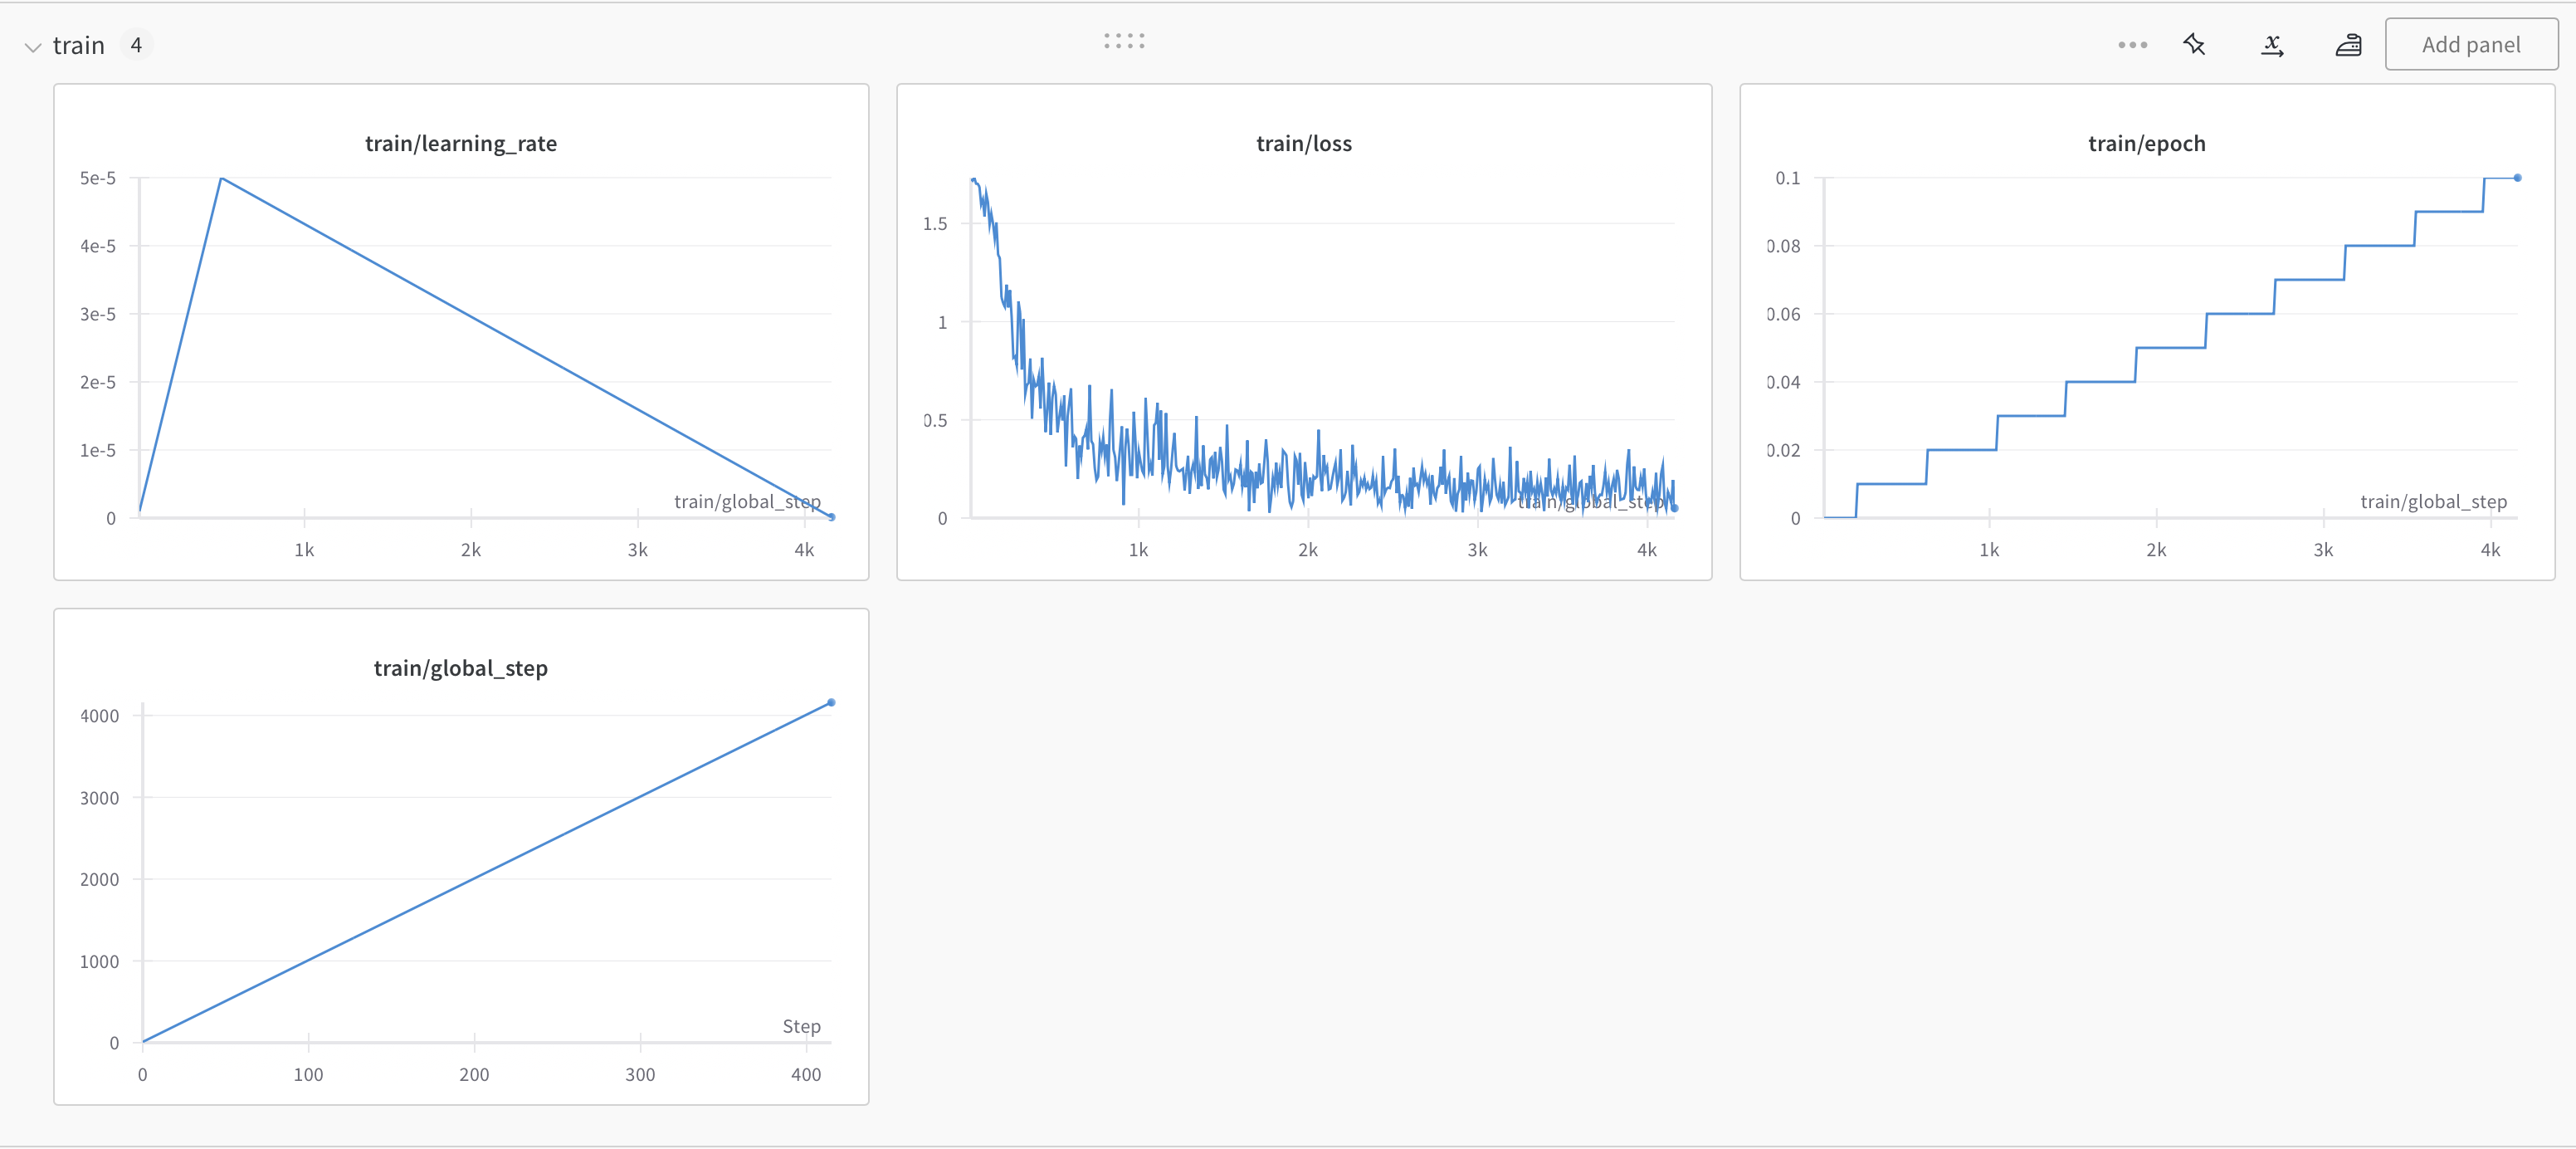

# **Inference**

Now that the model is trained, we can use it to make predictions on the test set.

You can also use it to make predictions on your own sentences by putting your sentence in the `texts` array.

In [17]:
import torch
import random

# sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
emotions_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def predict(texts, model, tokenizer):
    predictions = []
    # Ensure model is on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        # Move inputs to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        # Move logits to CPU for easier handling (optional)
        logits = logits.detach().cpu()
        predicted_class_id = logits.argmax(-1).item()
        predictions.append(predicted_class_id)
    return predictions

# Example usage
random_index = random.randint(0, df.shape[0])
texts = [df["text"][random_index]]
print("Texts: ", texts)
predictions = predict(texts, model, tokenizer)
print("Predicted: ", emotions_map[predictions[0]]) 
print("Actual: ", emotions_map[df["label"][random_index]])

['id stop feeling humiliated every time i thought of a great idea i knew it wouldnt even be worth bringing up whereas with other characters i know i can rush to you and tell you immediately']
Predicted:  sadness
Actual:  sadness


# **Save the model for future use**

In [18]:
# Save the model
model_path = "./model"  # Specify your path here
trainer.save_model(model_path)

# Save the tokenizer
tokenizer.save_pretrained(model_path)

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

# Thanks for reading !

You can contact me on [LinkedIn](https://www.linkedin.com/in/clement-florval/) if you have any questions or suggestions.